In [18]:
# Conectar google colab con google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
main_datasets_path = '/content/drive/MyDrive/LSMADEVOIR/homework4/datasets/'

I have some issue with my environnement google colab, my nltk doesn't work

In [20]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import nltk
import re
import os
import string
import joblib

from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

#download the necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### **Text Cleaning**

In [21]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

# Load the tweets dataset
tweets_df = pd.read_csv(main_datasets_path + 'tweets.csv')

# Text Cleaning
tweets_text = tweets_df['text']
words = [word_tokenize(tweet) for tweet in tweets_text]

# Remove punctuation from each word
table = str.maketrans('', '', string.punctuation)
stripped = [[w.translate(table) for w in tweet] for tweet in words]

# Convert to lowercase
lowercase = [[w.lower() for w in tweet] for tweet in stripped]

# Remove remaining tokens that are not alphabetic
alphabetic = [[word for word in tweet if word.isalpha()] for tweet in lowercase]

# Filter out stop words
stop_words = set(stopwords.words('english'))
filtered = [[w for w in tweet if not w in stop_words] for tweet in alphabetic]

# Reconstruct the DataFrame with the cleaned text and the original columns
tweets_df['cleaned_text'] = [' '.join(tweet) for tweet in filtered]
print(filtered[:10])  # print the first 10 cleaned tweets

[['virginamerica', 'dhepburn', 'said'], ['virginamerica', 'plus', 'added', 'commercials', 'experience', 'tacky'], ['virginamerica', 'nt', 'today', 'must', 'mean', 'need', 'take', 'another', 'trip'], ['virginamerica', 'really', 'aggressive', 'blast', 'obnoxious', 'entertainment', 'guests', 'faces', 'amp', 'little', 'recourse'], ['virginamerica', 'really', 'big', 'bad', 'thing'], ['virginamerica', 'seriously', 'would', 'pay', 'flight', 'seats', 'nt', 'playing', 'really', 'bad', 'thing', 'flying', 'va'], ['virginamerica', 'yes', 'nearly', 'every', 'time', 'fly', 'vx', 'ear', 'worm', 'go', 'away'], ['virginamerica', 'really', 'missed', 'prime', 'opportunity', 'men', 'without', 'hats', 'parody', 'https'], ['virginamerica', 'well'], ['virginamerica', 'amazing', 'arrived', 'hour', 'early', 'good']]


Here is all tweets clean, but I didn't deal with contracted words like "didn't" or "aren't" etc...

### **Clusteranalysis**

Topic #0:
jetblue dm http united americanair southwestair fleek fleet follow thanks

Topic #1:
usairways hold americanair southwestair flight nt united get phone help

Topic #2:
flight united usairways americanair nt thanks cancelled jetblue southwestair get

Topic #3:
southwestair united thanks jetblue much virginamerica awesome great service thank

Topic #4:
jetblue united southwestair http boarding pass americanair usairways nt like

Topic #0:


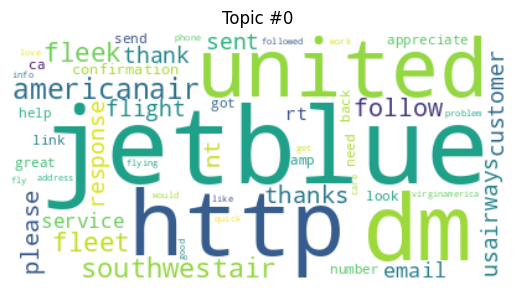

Topic #1:


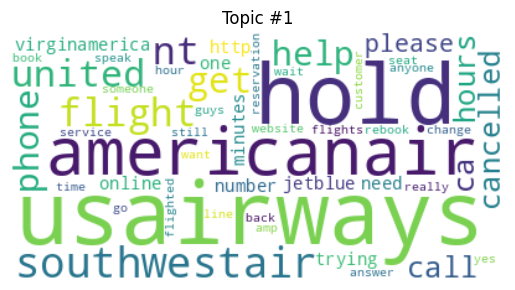

Topic #2:


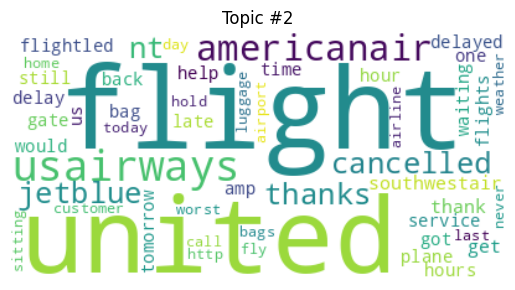

Topic #3:


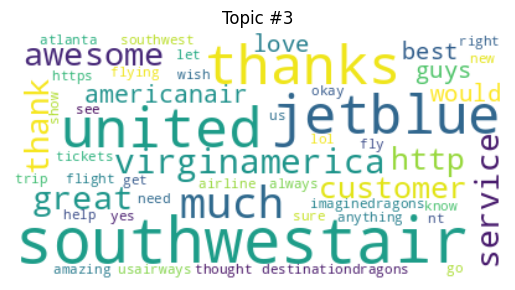

Topic #4:


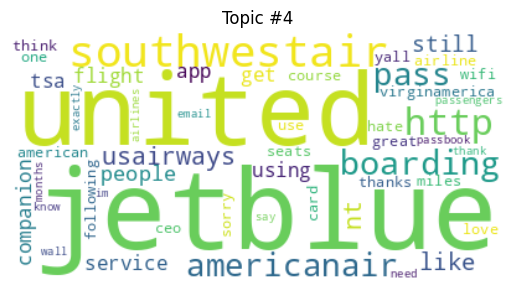

In [22]:
# Perform clustering analysis
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Vectorize the cleaned text
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(tweets_df['cleaned_text'])

# Perform LDA topic modeling
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Print the top words for each topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print()

print_top_words(lda, vectorizer.get_feature_names_out(), 10)

# Visualize the topics using a word cloud
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic #{topic_idx}:")
    wordcloud = WordCloud(max_words=50, background_color="white").fit_words(dict(zip(vectorizer.get_feature_names_out(), topic)))
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic #{topic_idx}")
    plt.show()


### **Tweet Classifier**

In [23]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X = tweets_df['cleaned_text']
y = tweets_df['airline_sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with a vectorizer and a classifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define the pipeline with TF-IDF vectorizer and Logistic Regression classifier
pipeline = Pipeline([
        ('vectorizer', TfidfVectorizer()),
        ('classifier', LogisticRegression(max_iter=1000))
    ])

# Train the pipeline on the training data
pipeline.fit(X_train, y_train)

# Evaluate the pipeline on the testing data
y_pred = pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Try other vectorizers and classifiers to compare results
# BoW vectorizer with Logistic Regression classifier
pipeline_bow = Pipeline([
        ('vectorizer', CountVectorizer()),
        ('classifier', LogisticRegression(max_iter=1000))
    ])
pipeline_bow.fit(X_train, y_train)
y_pred_bow = pipeline_bow.predict(X_test)
print("Accuracy (BoW):", accuracy_score(y_test, y_pred_bow))


Accuracy: 0.7988387978142076
Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.94      0.88      1889
     neutral       0.68      0.49      0.57       580
    positive       0.80      0.62      0.70       459

    accuracy                           0.80      2928
   macro avg       0.77      0.68      0.71      2928
weighted avg       0.79      0.80      0.79      2928

Confusion Matrix:
[[1770   84   35]
 [ 261  283   36]
 [ 121   52  286]]
Accuracy (BoW): 0.7988387978142076


In [24]:
from sklearn.naive_bayes import MultinomialNB

# Define the pipeline with TF-IDF vectorizer and Naive Bayes classifier
pipeline_nb_tfidf = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', MultinomialNB())
])

# Train the pipeline on the training data
pipeline_nb_tfidf.fit(X_train, y_train)

# Evaluate the pipeline on the testing data
y_pred_nb_tfidf = pipeline_nb_tfidf.predict(X_test)
print("Accuracy (Naive Bayes, TF-IDF):", accuracy_score(y_test, y_pred_nb_tfidf))
print("Classification Report (Naive Bayes, TF-IDF):")
print(classification_report(y_test, y_pred_nb_tfidf))
print("Confusion Matrix (Naive Bayes, TF-IDF):")
print(confusion_matrix(y_test, y_pred_nb_tfidf))

# Define the pipeline with BoW vectorizer and Naive Bayes classifier
pipeline_nb_bow = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB())
])

# Train the pipeline on the training data
pipeline_nb_bow.fit(X_train, y_train)

# Evaluate the pipeline on the testing data
y_pred_nb_bow = pipeline_nb_bow.predict(X_test)
print("Accuracy (Naive Bayes, BoW):", accuracy_score(y_test, y_pred_nb_bow))
print("Classification Report (Naive Bayes, BoW):")
print(classification_report(y_test, y_pred_nb_bow))
print("Confusion Matrix (Naive Bayes, BoW):")
print(confusion_matrix(y_test, y_pred_nb_bow))


Accuracy (Naive Bayes, TF-IDF): 0.7066256830601093
Classification Report (Naive Bayes, TF-IDF):
              precision    recall  f1-score   support

    negative       0.70      0.99      0.82      1889
     neutral       0.75      0.17      0.28       580
    positive       0.94      0.20      0.33       459

    accuracy                           0.71      2928
   macro avg       0.80      0.46      0.48      2928
weighted avg       0.75      0.71      0.64      2928

Confusion Matrix (Naive Bayes, TF-IDF):
[[1877   12    0]
 [ 474  100    6]
 [ 346   21   92]]
Accuracy (Naive Bayes, BoW): 0.7797131147540983
Classification Report (Naive Bayes, BoW):
              precision    recall  f1-score   support

    negative       0.79      0.95      0.86      1889
     neutral       0.67      0.40      0.50       580
    positive       0.81      0.56      0.66       459

    accuracy                           0.78      2928
   macro avg       0.76      0.64      0.68      2928
weighted avg